# LSTM Multiclass Classification

In [6]:
import pandas as pd
import seaborn as sns
import nltk
import json
import wandb
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import numpy as np
from wandb.integration.keras import WandbMetricsLogger

In [7]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.utils.pad_sequences
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
EarlyStopping = tf.keras.callbacks.EarlyStopping

In [8]:
config_data = json.load(open('../config.json'))
HF_TOKEN = config_data['HF_TOKEN']
WANDB_TOKEN = config_data['WANDB_TOKEN']

wandb.login(key=WANDB_TOKEN)

run = wandb.init(
    project='wz_lstm_classifier',
    config={"model_name": "LSTM"}
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [9]:
config = wandb.config

config.maxlen = 12700
config.vocab_size = 39000
config.embedding_dims = 100
config.epochs = 10
config.hidden_dims = 100
config.batch_size = 64

id_to_label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
label_to_id_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
cefr_levels = ["A1", "A2", "B1", "B2", "C1", "C2"]

In [10]:
df = pd.read_csv('../datasets/archived/all_combined.csv')

In [11]:
df.head()

,text,level
0,Do you need something to eat ?,A1
1,I have two fish in a bowl .,A1
2,She wanted the grey coat .,A1
3,I sent my girlfriend red roses .,A1
4,She needs to use your phone .,A1


In [12]:
df.describe()

,text,level
count,17024,17024
unique,17022,6
top,She used to eat meat. She used to eat a lot of...,B2
freq,2,4537


<Axes: xlabel='level', ylabel='count'>

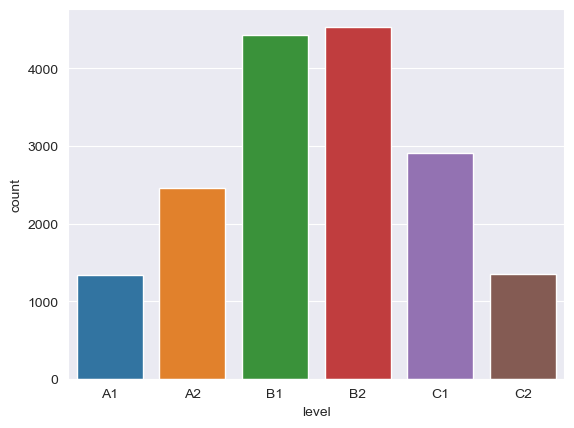

In [13]:
sns.countplot(x='level',data=df)

In [14]:
df['level'].value_counts()

level
B2    4537
B1    4431
C1    2906
A2    2464
C2    1353
A1    1333
Name: count, dtype: int64

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kawis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
ps = PorterStemmer()

In [17]:
df_text = df['text']
df_level = df['level']

In [18]:
df['text_length'] = df['text'].apply(len)
text_max_length = df['text_length'].max()
print(f"The maximum length of text in the dataset is: {text_max_length}")

The maximum length of text in the dataset is: 12670


In [19]:
corpus = []
for i in range(len(df_text)):
    x = df_text[i]
    temp = re.sub('[^a-zA-Z0-9]',' ',x)
    temp = temp.lower()
    temp = temp.split()
    
    temp = [ps.stem(word) for word in temp if not word in stopwords.words('english')]
    temp = ' '.join(temp)
    corpus.append(temp)

In [20]:
df_text[0]

'Do you need something to eat ?'

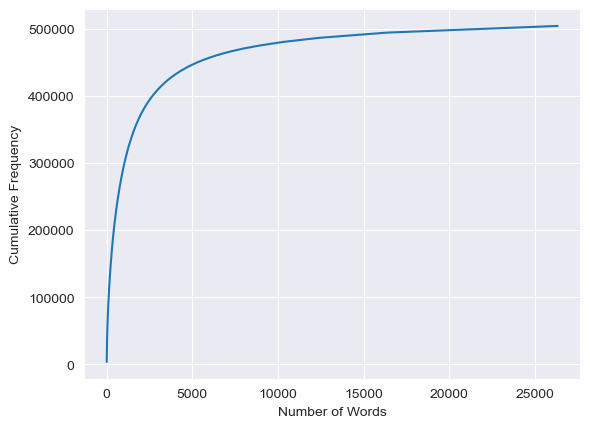

Number of unique words in the dataset: 26336


In [21]:
all_words = ' '.join(corpus).split()
word_freq = Counter(all_words)
common_words, counts = zip(*word_freq.most_common())
cumulative_counts = np.cumsum(counts)
unique_words = set(all_words)
num_unique_words = len(unique_words)

plt.plot(cumulative_counts)
plt.xlabel('Number of Words')
plt.ylabel('Cumulative Frequency')
plt.show()
print(f"Number of unique words in the dataset: {num_unique_words}")

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kawis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
y = pd.get_dummies(df['level'],columns=df["level"]).values
y

array([[ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       ...,
       [False, False, False, False, False,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False,  True]])

In [24]:
x_train,x_test,y_train,y_test = train_test_split(corpus,y,test_size=0.4,random_state=24)

In [25]:
print(y_train[:5])
print(y_test[:5])

[[False False False False  True False]
 [False False False  True False False]
 [False  True False False False False]
 [False False  True False False False]
 [False False False  True False False]]
[[ True False False False False False]
 [False False False  True False False]
 [False False False  True False False]
 [False  True False False False False]
 [ True False False False False False]]


In [26]:
tokenizer = Tokenizer(num_words=config.vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',lower=True)
tokenizer.fit_on_texts(x_train)

In [27]:
word_index = tokenizer.word_index
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

In [28]:
x_train = pad_sequences(x_train_sequences,padding='pre', maxlen=config.maxlen)
x_test = pad_sequences(x_test_sequences,padding='pre', maxlen=config.maxlen)

In [29]:
print(f'Started LSTM training and evaluation at {datetime.datetime.now()}')
model = Sequential()
model.add(Embedding(config.vocab_size, config.embedding_dims, input_length=config.maxlen))
model.add(LSTM(config.hidden_dims, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Started LSTM training and evaluation at 2024-08-14 21:11:00.199717


C:\Users\kawis\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
history = model.fit(
    x_train,y_train, 
    epochs=config.epochs, 
    batch_size=config.batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), WandbMetricsLogger()]
)

Epoch 1/10
  1/144 ━━━━━━━━━━━━━━━━━━━━ 5:39:57 143s/step - accuracy: 0.0625 - loss: 1.7931

KeyboardInterrupt: 

In [ ]:
def get_performance_metrics(y_test_l, y_pred_l):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_l, y_pred_l))

    print("\nClassification Report:")
    print(classification_report(y_test_l, y_pred_l))

    print("Balanced Accuracy Score:", balanced_accuracy_score(y_test_l, y_pred_l))
    print("Accuracy Score:", accuracy_score(y_test_l, y_pred_l))

In [ ]:
accuracy = model.evaluate(x_test,y_test)
print(accuracy[0],accuracy[1])

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
wandb.log({"Loss Plot": plt})

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
wandb.log({"Accuracy Plot": plt})

In [ ]:
def make_predictions(p_model, p_test, x_test):
    print(f'Started prediction at {datetime.datetime.now()}')
    for index, row in p_test.iterrows():
        sentence = x_test[index]
        pred = p_model.predict(sentence)
        p_test.loc[index, 'predictions'] = cefr_levels[np.argmax(pred)]

revert_y_train = pd.from_dummies(pd.DataFrame(y_train, columns=cefr_levels))
revert_y_test = pd.from_dummies(pd.DataFrame(y_test, columns=cefr_levels))
d={'label': revert_y_test}
new_test = pd.DataFrame(data=d)
make_predictions(model, new_test, revert_y_test, x_test)
print(f'Ended prediction at {datetime.datetime.now()}')

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = new_test['predictions']

y_true = new_test['label']

def map_func(x):
    return label_to_id_mapping.get(x, -1)

y_true_mapped = np.vectorize(map_func)(y_true)
y_pred_mapped = np.vectorize(map_func)(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
print(f'Accuracy: {accuracy:.3f}')

# Generate accuracy report
unique_labels = set(y_true_mapped)  # Get unique labels

for label in unique_labels:
    label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
    label_y_true = [y_true_mapped[i] for i in label_indices]
    label_y_pred = [y_pred_mapped[i] for i in label_indices]
    label_accuracy = accuracy_score(label_y_true, label_y_pred)
    print(f'Accuracy for label {cefr_levels[label]}: {label_accuracy:.3f}')

class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))))
class_report_dict = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=cefr_levels, labels=list(range(len(cefr_levels))), output_dict=True)
print('\nClassification Report:')
print(class_report)
table_data = []

for key, value in class_report_dict.items():
    if isinstance(value, dict):
        table_data.append([
            key,
            value.get("precision", 0),
            value.get("recall", 0),
            value.get("f1-score", 0),
            value.get("support", 0)
        ])
    else:
        # For accuracy, add precision and recall as 0
        table_data.append([
            key,
            0,
            0,
            value,
            class_report_dict["weighted avg"]["support"]
        ])

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(cefr_levels))))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=cefr_levels)
disp.plot()


print('\nConfusion Matrix:')
print(conf_matrix)

wandb.log({
    "Class Proportions": wandb.sklearn.plot_class_proportions(revert_y_train, new_test['label'], cefr_levels),
    "Confusion Matrix": plt,
    "Classification Report": wandb.Table(data=table_data, columns=['Class/Metric', 'Precision', 'Recall', 'F1-score', 'Support'])
})

In [ ]:
print(f'Ended LSTM training and evaluation at {datetime.datetime.now()}')
wandb.finish()